In [1]:
from comet_ml import Experiment
import numpy as np
import os
import sys


DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)
from features.tidy_data import tidy_data
from visualizations.simple_visualization import *
from feature_eng1 import *

In [2]:
# with open('../../COMET_API_KEY.txt', 'r') as f:
#     my_key = f.read()

# experiment = Experiment(
#   api_key=my_key,
#   project_name="nhl-project-b10",
#   workspace="ift6758b-project-b10"
# )

### We split the data into training, validation and test sets:

#### Train set(including validation set): 2016/2017-2019/2020
#### Test set : 2020/2021

## Question 1

In [3]:
# train_df = generate_train_set(DATA_PATH)
# train_df

In [4]:
# save the train_df
# train_df.to_csv('train_df.csv', index=False)
train_df = pd.read_csv('train_df.csv')
train_df    

,game_id,homeTeam,awayTeam,periodType,period,periodTime,team,eventType,x_coordinate,y_coordinate,goal_location,shooter,goalie,shotType,emptyNet,strength,shot_angle,shot_distance,is_goal,distance_bin
0,2018020030,CHI,TOR,REGULAR,2,08:18,CHI,Shot,78.0,19.0,Right,Jonathan Toews,Garret Sparks,Wrist Shot,0,NaN,59.931417,21.954498,0,"(19.264, 28.895]"
1,2018020124,MTL,CGY,REGULAR,3,11:10,CGY,Goal,78.0,-4.0,Right,Elias Lindholm,Carey Price,Wrist Shot,0,EVEN,19.983107,11.704700,1,"(9.632, 19.264]"
2,2017021048,BOS,CHI,REGULAR,1,01:40,BOS,Shot,60.0,-20.0,Left,Tommy Wingels,J-F Berube,Snap Shot,0,NaN,7.645013,150.336290,0,"(144.476, 154.108]"
3,2018020774,NYR,PHI,REGULAR,2,15:14,PHI,Shot,-79.0,1.0,Left,Jakub Voracek,Alexandar Georgiev,Wrist Shot,0,NaN,5.710593,10.049876,0,"(9.632, 19.264]"
4,2019020420,NYR,VGK,REGULAR,1,18:41,VGK,Shot,74.0,7.0,Right,William Karlsson,Henrik Lundqvist,Backhand,0,NaN,25.016893,16.552945,0,"(9.632, 19.264]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,2016020269,ARI,SJS,REGULAR,3,02:56,ARI,Shot,55.0,-30.0,Left,Max Domi,Martin Jones,Wrist Shot,0,NaN,11.768289,147.091808,0,"(144.476, 154.108]"
327338,2016020969,WSH,DAL,REGULAR,2,17:11,DAL,Shot,-60.0,25.0,Left,Adam Cracknell,Philipp Grubauer,Snap Shot,0,NaN,40.763605,38.288379,0,"(28.895, 38.527]"
327339,2018021055,EDM,TOR,REGULAR,1,00:26,EDM,Shot,50.0,-35.0,Left,Adam Larsson,Frederik Andersen,Wrist Shot,0,NaN,14.133191,143.338760,0,"(134.845, 144.476]"
327340,2019020898,FLA,EDM,REGULAR,3,08:45,FLA,Goal,-82.0,-16.0,Left,Jonathan Huberdeau,Mikko Koskinen,Slap Shot,0,EVEN,66.370622,17.464249,1,"(9.632, 19.264]"


In [5]:
train_df[train_df['shot_distance'] == 1]

,game_id,homeTeam,awayTeam,periodType,period,periodTime,team,eventType,x_coordinate,y_coordinate,goal_location,shooter,goalie,shotType,emptyNet,strength,shot_angle,shot_distance,is_goal,distance_bin
82162,2017021085,PHI,CBJ,REGULAR,2,00:14,PHI,Goal,90.0,0.0,Right,Shayne Gostisbehere,Sergei Bobrovsky,Snap Shot,0,PPG,0.0,1.0,1,"(0.0, 9.632]"


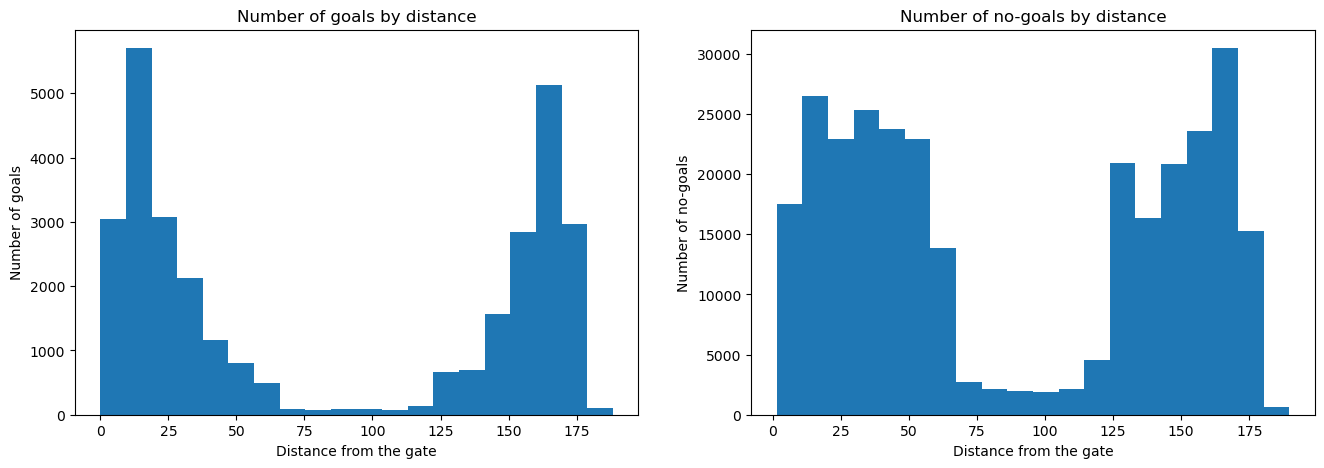

In [6]:
bin_by_distance(train_df)

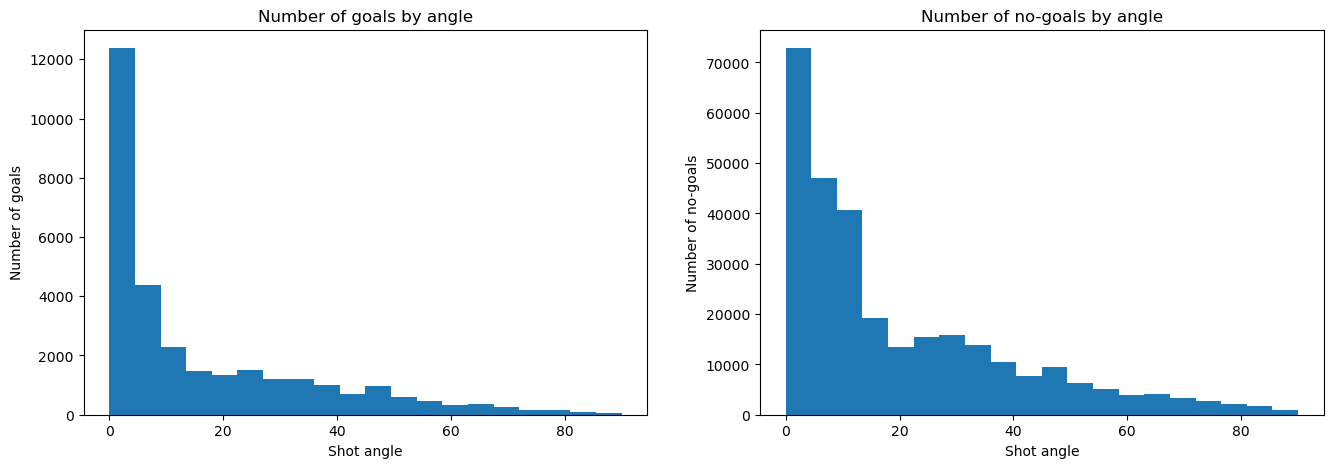

In [7]:
bin_by_angle(train_df)

<Figure size 800x500 with 0 Axes>

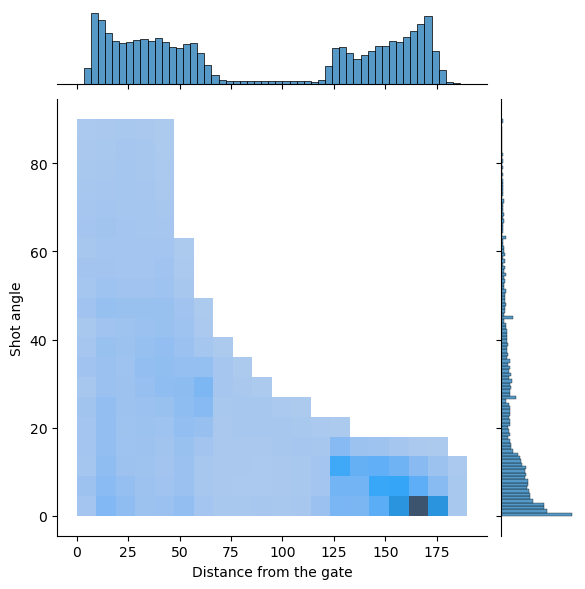

In [8]:
joint_plot(train_df)

## Question 2

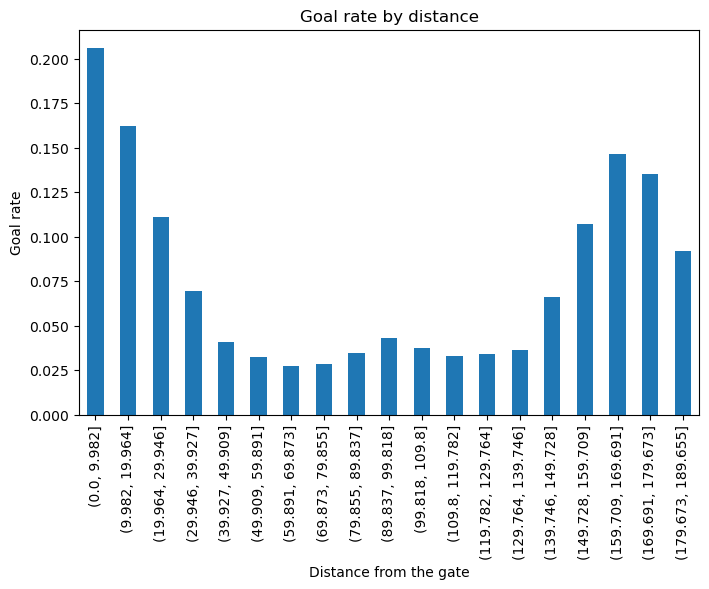

In [9]:
prob_by_distance(train_df)

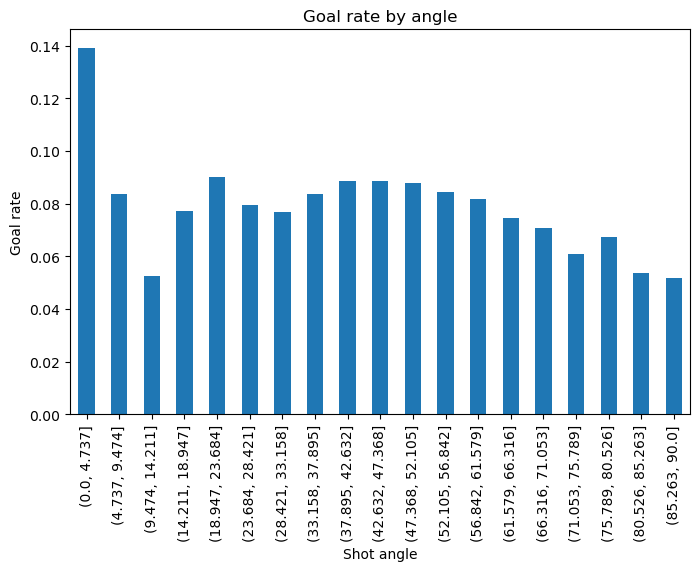

In [10]:
prob_by_angle(train_df)

## Question 3

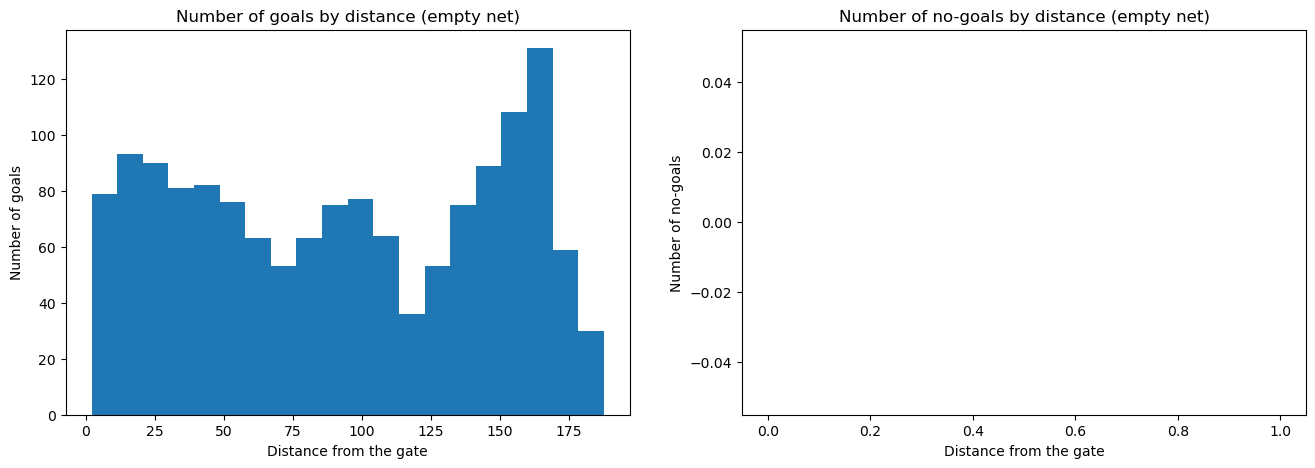

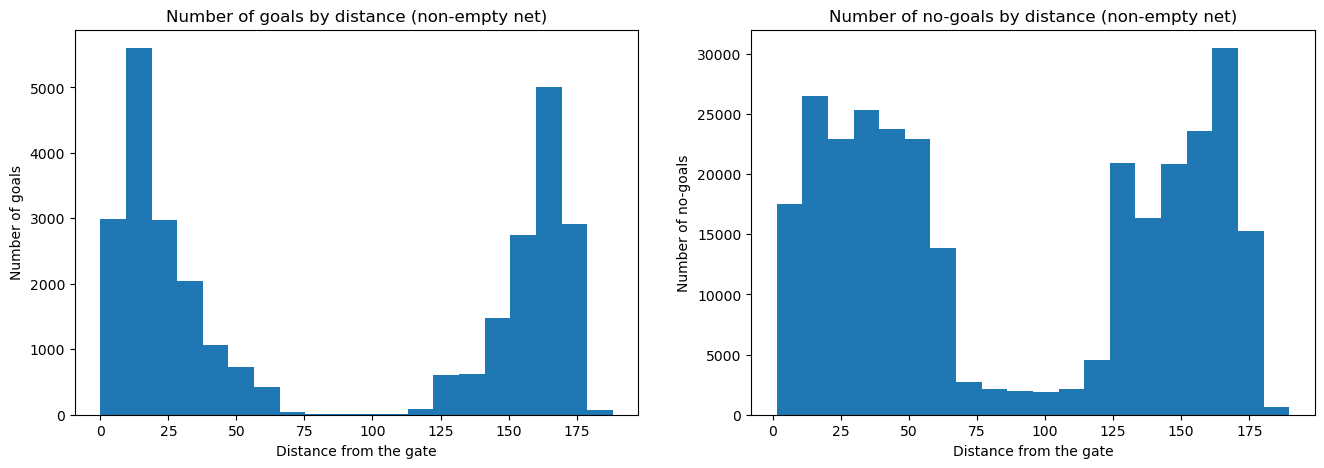

In [11]:
check_emptyNet(train_df)